# Normalisation Histogram
## Manual Contrast Stretching
Task:

- Read cameraman.png as grayscale.

- Find the real min and max pixel values in the image.

- Implement the Linear Stretching Formula manually using Numpy (No cv.normalize).

- Show the original and the new image side-by-side.

- Constraint: Do not use for loops. Use Numpy vectorization.

    - important note:

        ```text
        # WRONG (uint8 overflow risk)
        # res = (img - min_val) * 255 / (max_val - min_val) 

        # CORRECT
        img_float = img.astype(float)
        res = (img_float - min_val) * 255.0 / (max_val - min_val)
        res_uint8 = res.astype(np.uint8)
        ```

(np.float64(-0.5), np.float64(250.5), np.float64(250.5), np.float64(-0.5))

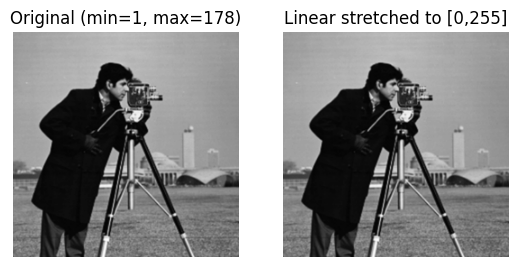

In [74]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# cv.IMREAD_GRAYSCALE is the same as 0 for reading an image in grayscale mode
cameraman_img = cv.imread("img/cameraman2.png", cv.IMREAD_GRAYSCALE)
# cameraman_img=cv.imread("img/cameraman2.png",0)

# to prevent overflow risk I change image type to float before calculating normalization
cameraman_img_float = cameraman_img.astype(float)
min_val = cameraman_img.min()
max_val = cameraman_img.max()
new_image = (cameraman_img_float - min_val) * 255 / (max_val - min_val)

# change new_image type to uint8
new_image_uint8 = new_image.astype(np.uint8)

plt.subplot(1, 2, 1)
plt.title(f"Original (min={min_val}, max={max_val})")
plt.imshow(cameraman_img, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Linear stretched to [0,255]")
plt.imshow(new_image_uint8, cmap="gray")
plt.axis("off")

# Equalisation Histogram
- OpenCV Way (Black Box)
    ```bash
    equalized_img = cv.equalizeHist(img)
    ```
- numpy way:
    1. Get Histogram
        ```bash
        hist, bins = np.histogram(img.flatten(), 256, [0,256])
        ```

    2. Get CDF
        ```bash
        cdf = hist.cumsum()
        ```

    3. Normalize CDF (so max is 255)
        ```bash
        cdf_normalized = cdf * 255 / cdf.max()
        ```

    4. Map
    - We use the CDF as a "Look Up Table" (LUT).
    - If pixel value is 'v', new value is cdf_normalized[v]
        ```bash
        equalized_img = cdf_normalized[img]
        ```

Conceptual Question: 

Imagine an image that contains only two values: 50% of pixels are Black (0) and 50% of pixels are White (255).

1. What does the Histogram look like?

2. What does the CDF look like? (at 0, at 128, at 255)

3. If we apply Histogram Equalization to this specific image, will it change?

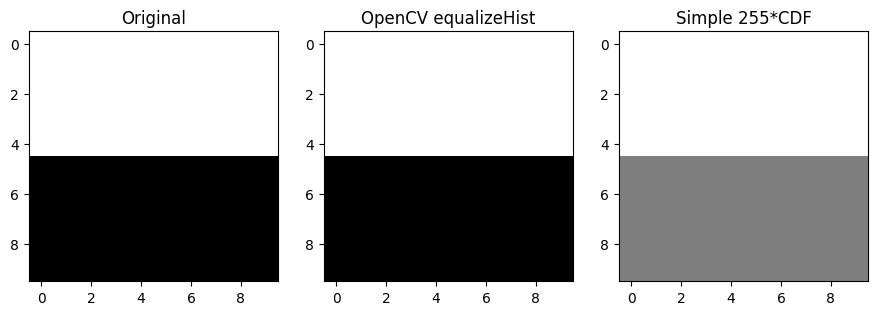

LUT_simple[0] = 127 LUT_simple[255] = 255


In [75]:
img = np.zeros((10, 10), dtype=np.uint8)
img[0:5, :] = 255

# histogram + CDF
hist1 = np.bincount(img.ravel(), minlength=256)
cdf1 = hist1.cumsum() / hist1.sum()

# "simplified" equalization LUT: new = 255 * CDF(old)
lut_simple = np.floor(255 * cdf1).astype(np.uint8)

eq_simple = lut_simple[img]                 # apply LUT
eq_opencv = cv.equalizeHist(img)            # OpenCV equalization

plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.title("Original"); plt.imshow(img, cmap="gray", vmin=0, vmax=255); 
plt.subplot(1,3,2); plt.title("OpenCV equalizeHist"); plt.imshow(eq_opencv, cmap="gray", vmin=0, vmax=255); 
plt.subplot(1,3,3); plt.title("Simple 255*CDF"); plt.imshow(eq_simple, cmap="gray", vmin=0, vmax=255); 
plt.tight_layout(); plt.show()

print("LUT_simple[0] =", lut_simple[0], "LUT_simple[255] =", lut_simple[255])


Example 1 (easy: only 4 gray levels)
Image A (10×10)

Values are only in {0, 64, 128, 255}:
```bash
A =
0   0   0   0   0   64  64  64  64  64
0   0   0   0   0   64  64  64  64  64
0   0   0   0   0   64  64  64  64  64
0   0   0   0   0   64  64  64  64  64
0   0   0   0   0   64  64  64  64  64
128 128 128 128 128 255 255 255 255 255
128 128 128 128 128 255 255 255 255 255
128 128 128 128 128 255 255 255 255 255
128 128 128 128 128 255 255 255 255 255
128 128 128 128 128 255 255 255 255 255
```

tasks for A:

- Histogram?
- Normalized histogram? 
- Contrast stretching (min–max)?
- Histogram equalization?


In [76]:
# Define Image A based on the description
# Rows 0-4 (5 rows): Cols 0-4 (5 cols): 0, Cols 5-9 (5 cols): 64
# Rows 5-9 (5 rows): Cols 0-4 (5 cols): 128, Cols 5-9 (5 cols): 255
A = np.zeros((10, 10), dtype=np.uint8)
A[0:5, 0:5] = 0
A[0:5, 5:10] = 64
A[5:10, 0:5] = 128
A[5:10, 5:10] = 255

# 1. Histogram (counts)
hist, bins = np.histogram(A.flatten(), 256, [0, 256])

# 2. Normalized Histogram
total_pixels = A.size  # 10 * 10 = 100
# probab
prob_hist = hist / total_pixels
# print(prob_hist.sum()) # must be 1

# 3. Contrast Stretching
min_gray = A.min()
max_gray = A.max()
# safty check: If the image has constant intensity (e.g. all pixels = 128):
# (max_gray == min_gray)
if max_gray == min_gray:
    A_stretched = A.copy()
else:
    A_stretched = (A - min_gray) * 255 / (max_gray - min_gray)


# 4. Histogram Equalization
# cdf
cdf = hist.cumsum()
print(cdf)
# normalize cdf -> cdf*255/cdf.max()
normalized_cdf = cdf * 255 / cdf.max()
# using normalized_cdf as LUT to create the new image
# LUT= normalized_cdf ==> imagine this as a dictionnary:
# normalized_cdf= {0:64 , 64:128 , 128:191 , 255:255 } ={key,value}
# equalized_new_A= normalized_cdf [key]
equalized_new_A = normalized_cdf[A]
print(f"old A: {np.histogram(A)}")
print(f"equalized A: {np.histogram(equalized_new_A)}")

[ 25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25
  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25
  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25
  25  25  25  25  25  25  25  25  25  25  50  50  50  50  50  50  50  50
  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75
  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75
  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75
  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75
  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75
  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75  75
  75  75  75  75  75  75  75  75  75  75  75  75  7

Task:

Write a function equalize_manual(image) that:

- Calculates the histogram of the input image.
- Computes the CDF.
- Normalizes the CDF to range $[0, 255]$.
- Uses Numpy indexing (LUT) to map the old pixels to new pixels.
- Returns the equalized image.

(array([[33.,  3.,  0., ..., 26., 17.,  8.],
        [28.,  1.,  0., ..., 22., 25.,  5.],
        [30.,  3.,  0., ..., 23., 23.,  2.],
        ...,
        [19.,  3.,  0., ...,  8., 18., 25.],
        [21.,  1.,  0., ..., 11., 19., 20.],
        [21.,  1.,  0., ...,  9., 17., 22.]], shape=(263, 10)),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 263 BarContainer objects>)

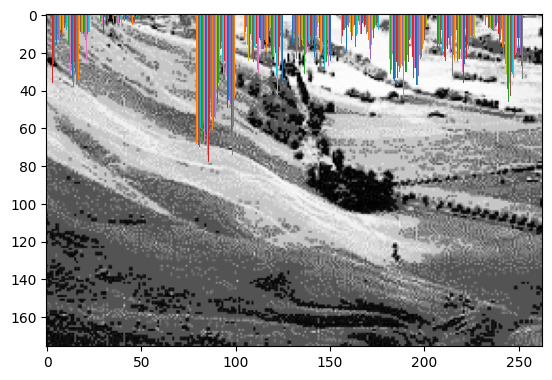

In [80]:
def equalize_manual(image):
    # Histogram (counts)
    hist, bins = np.histogram(image.flatten(), 256, [0, 256])
    # cdf
    cdf = hist.cumsum()
    # normalize cdf -> cdf*255/cdf.max()
    normalized_cdf = cdf * 255 / cdf.max()
    # using normalized_cdf as LUT to create the new image
    equalized_new_image = normalized_cdf[image]
    return equalized_new_image.astype(np.uint8)

landscape=cv.imread("img/landscape.png",0)
plt.imshow(equalize_manual(landscape),cmap="gray")
plt.hist(equalize_manual(landscape))

Code Review:
equalize_manual is logically correct, but there is one dangerous type error:
- normalized_cdf is float.normalized_cdf[image] 
- returns an image of float.

Fix: Always cast the LUT to uint8 before applying it: 
```python
normalized_cdf = (cdf * 255 / cdf.max()).astype(np.uint8).
```

- Why? 

If you pass this float image to OpenCV later, it expects floats to be $0.0-1.0$. Your values are $0.0-255.0$. It will appear all white.

---

# Thresholding (Seuillage)
use it If we want a mask on specific part of the image (Coins = White, Table = Black). This binary decision is called Thresholding.

1️⃣ **Physical & Intuitive Foundations**
**The Coin Project Context:** You have a photo: **Bright Coins** on a **Dark Table**.
- We don't care about the texture of the wood.
- We don't care about the shiny scratches on the coin.
- We only care about ONE question: "Is this pixel part of a coin, or part of the table?"

**Thresholding is the decision process:**
- "If the pixel is brighter than value $T$, it is a Coin (1)."
- "If the pixel is darker than value $T$, it is Background (0)."

This converts a Grayscale image (0-255) into a Binary image (0 or 1).

---

2️⃣ **Formal Course Content**

**Simple Thresholding (Binary)**
Let $f(x,y)$ be the input image and $T$ be the threshold. The output binary image $g(x,y)$ is defined as:

$$g(x, y) = \begin{cases} 255 (\text{White}) & \text{if } f(x, y) > T \\0 (\text{Black}) & \text{if } f(x, y) \le T \end{cases}$$

$$(Note: We use 255 for "True" so we can see it as white, but logically it is 1).$$

**The "Double Threshold" (Band-Pass)**
Sometimes we want to select a range (e.g., "Gray coins" on "Black table" with "White Glare").
$$g(x, y) = \begin{cases} 255 & \text{if } T_1 < f(x, y) < T_2 \\ 0 & \text{otherwise} \end{cases}$$

---

#### Method A: OpenCV (Standard)
```Python
# ret is the threshold used (useful later for automatic methods)
# res is the binary image
ret, res = cv.threshold(img, 127, 255, cv.THRESH_BINARY)
```

#### Method B: Numpy (Vectorized - The Mastery Way)
```Python
# Create a boolean mask
mask = img > 127 
# Convert to uint8 (0 or 255)
res = (mask * 255).astype(np.uint8)
```
---

**Scenario:**
You are detecting euro coins.
- Background pixels are around gray level 50.
- Coin pixels are around gray level 200.
- However, there is a shadow on the right side of the image where the table is 30 and the coin is 100.

**Question:** If you choose a global threshold $T = 150$:

- What happens to the bright coins (200)?
- What happens to the coins in the shadow (100)?Is this a problem? 
- How would you describe the result?

answer: it assumes uniform lighting. If you have a shadow, the "Coin" in the shadow ($100$) looks like the "Table" in the light ($100$). A single number $T$ cannot separate them.
But the rest of coins($200$) become white and the rest of table will be black. 


**To solve the problem above**, we have two major tools in Image Analysis:
1. **Adaptive Thresholding**: We calculate a different $T$ for every pixel based on its neighbors (solves the shadow problem).
2. **Otsu's Method**: We find the best possible Global Threshold automatically (solves the "guessing" problem).


```text
                    we start with Otsu's method
```

## Otsu's Binarization (Automatic Thresholding)

**The Problem:**
You have 1000 images of coins. Some are bright, some are dark. You cannot manually type `T=150`, `T=120`, `T=180` for each one. You need an algorithm that looks at the **Histogram** and picks the best .

### 1️⃣ Intuitive Foundation

Imagine the Histogram again. You have two "mountains":

* Mountain A: Background pixels.
* Mountain B: Coin pixels.

Otsu's algorithm tries to put a line  between them.
How does it decide?
It searches for the split where the two resulting clusters are as **tight** (low variance) as possible.

* If  is wrong (cuts through a mountain), the variance of that cluster will be huge (mixed light and dark).
* If  is right (valley), both clusters have low variance.

### 2️⃣ Formal Course Content

We iterate through all possible thresholds .
For each , we split the pixels into two classes:

* **Class 0 (Background):** Pixels 
* **Class 1 (Foreground):** Pixels 

We calculate the **Within-Class Variance** :


* : Weights (probabilities)  What % of pixels are in this class?
* : Variances of the pixel values in each class.

**Goal:** Find  that **minimizes** .

---

### 3️⃣ Code Translation (The "Smart Loop" Strategy)

We do **not** loop over pixels. We loop over **thresholds** (0 to 255).
Inside the loop, we use boolean masking (vectorization) to get the pixels.

```python
# Pseudo-code logic
best_thresh = 0
min_variance = infinity

for t in range(256):
    # 1. Split logic
    background_pixels = image[image <= t]
    foreground_pixels = image[image > t]
    
    # 2. Compute weights (w0, w1)
    # 3. Compute variances (var0, var1)
    # 4. Compute weighted variance sum
    # 5. Update minimum
```

4️⃣ Understanding Check (STOP)
**Scenario**: You run Otsu's algorithm on a purely white image (all pixels are 255).
- Will Otsu find a good threshold to separate objects?
- Why or why not? (Think about the "two mountains" theory).